# Load Models and Data

In [239]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.model_selection import KFold

In [240]:
def get_auc(results, y_test, y_pred):
    y_pred_proba = results.predict_proba(X_test)
    y_pred_proba_1 = [x[1] for x in y_pred_proba]
    pr = roc_curve(y_test, y_pred_proba_1)
    return auc(pr[0], pr[1])

In [241]:
from utils import cost_function, coster, get_scores

In [242]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [222]:
df.shape

(440666, 65)

In [243]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "disturbance_events", "number_affected", "net_generation_megawatthours"]

# Checking Correlations

In [223]:
df_ng.shape

(268454, 1708)

In [6]:
# Label encode categorical fields so that they can be correlated
df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_ng[not_encode].reset_index()
temp2 = df_ng[to_encode].apply(le.fit_transform).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [7]:
corr = df_ng.corr()

In [8]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['disturbance_events', 'number_affected', 0.7655082998226197],
 ['number_affected', 'disturbance_events', 0.7655082998226197],
 ['mmbtu_per_unit_gen', 'reported_prime_mover', 0.4551813724903194],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportation_mode', 'purchase_type', 0.2942462825380524],
 ['purchase_type', 'primary_transportation_mode', 0.294246282538

Some obvious correlations in here, like gas supply and delivery contract type or disturbance events and number affected (by disturbance events). It helps give an idea of the data, btu it doesn't indicate any changes to features.

### Checking Correlations Involving Fuel Cost

In [9]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'number_affected', 0.016547105838107864],
 ['fuel_cost', 'regulated', nan],
 ['number_affected', 'fuel_cost', 0.016547105838107864],
 ['fuel_cost', 'disturbance_events', 0.008163806819898293],
 ['disturbance_events', 'fuel_cost', 0.008163806819898293],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type', 0.0006275626240884574],
 ['natural_gas_supply_contract_type', 'fuel_cost', 0.0006275626240884574],
 ['fuel_cost', 'natu

Interesting that disturbance events and number affected are correlated to fuel cost, but the correlation is not high. Same for other correlations: interesting but not strong enough to infer anything. On to modelling.

In [299]:
df.columns

Index(['average_ash_content', 'average_heat_content',
       'average_mercury_content', 'average_sulfur_content', 'chlorine_content',
       'coalmine_county', 'coalmine_msha_id', 'coalmine_name',
       'coalmine_state', 'coalmine_type', 'contract_expiration_date',
       'contract_type', 'energy_source', 'fuel_cost', 'fuel_group',
       'moisture_content', 'month', 'natural_gas_delivery_contract_type',
       'natural_gas_supply_contract_type',
       'natural_gas_transportation_service', 'operator_id', 'operator_name',
       'plant_id', 'plant_name', 'plant_state', 'primary_transportation_mode',
       'purchase_type', 'quantity', 'regulated', 'reporting_frequency',
       'secondary_transportation_mode', 'supplier', 'year', 'plant_id_gen',
       'combined_heat_and_power_plant', 'plant_name_gen', 'operator_name_gen',
       'state_gen', 'census_region', 'nerc_region', 'reserved_', 'naics_code',
       'eia_sector_number', 'sector_name', 'reported_prime_mover',
       'reported_fu

# Modelling

In [244]:
def get_ng():
    df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_ng[not_encode].reset_index()
    temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
    df_ng = temp1.merge(temp2, on="index").set_index("index")
    return df_ng

In [245]:
def get_xy():
    X = df_ng.drop(columns=["fuel_cost"])
    y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))
    return X, y

## Train-Test Split

In [273]:
df_ng = get_ng()
X, y = get_xy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [163]:
results.score(X_test, y_test)

0.9116943684951612

Decent score for accuracy, indicating better than baseline == "no price spikes" for the imbalanced model (p=.9). But f1 score will be the better determinant.

In [201]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.7181767648693719
Recall: 0.24199288256227758
F1: 0.3620061641916503
       0     1
0  47845   507
1   4047  1292
Cost Function: -0.015731876629165188


Decent. All scores around 70 is not bad. Cost function is negative indicating a net benefit to  using the model.

## ROC Curve

In [290]:
X,y = get_xy()

In [291]:
y_pred_proba = results.predict_proba(X_test)

In [292]:
y_pred_proba_1 = [x[1] for x in y_pred_proba]

In [294]:
pr = roc_curve(y_test, y_pred_proba_1)

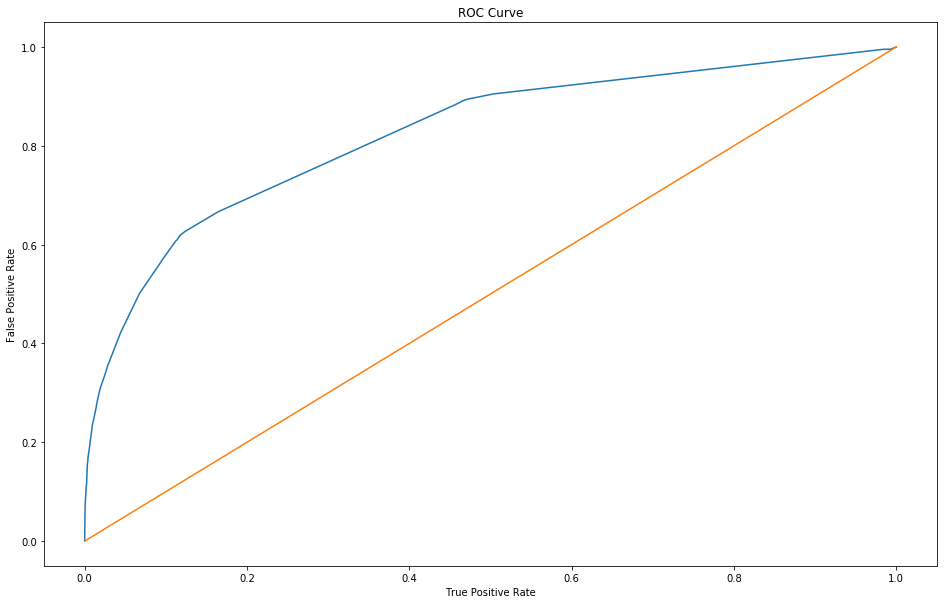

In [293]:
fig = plt.figure(figsize=(16,10))
plt.title("ROC Curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.plot(pr[0], pr[1])
plt.plot(pr[0],pr[0])

In [295]:
auc(pr[0], pr[1])

0.7314337362886443

## K Folds

In [247]:
df_ng = get_ng()
X, y = get_xy()

In [281]:

def get_scores(y_test, y_pred, X):
    from sklearn.metrics import f1_score, recall_score, precision_score
    precision = precision_score(y_test, y_pred)
    recall =  recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cost = cost_function(y_test, y_pred, X)
    
    print("Precision: %s" % precision)
    print("Recall: %s" % recall)
    print("F1: %s" % f1)
    print("Cost Function: %s" % cost)
    return {"precision": precision, "recall": recall, "f1": f1, "cost": cost}

In [286]:
scores = []

for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=23, max_depth=10)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    scores.append(get_scores(y_test, y_pred, X_test))

       0    1
0  35190  350
1  17465  686
Precision: 0.6621621621621622
Recall: 0.037794060933281914
F1: 0.07150674936154687
Cost Function: -0.4262904463960912
       0    1
0  50935  443
1   1935  378
Precision: 0.46041412911084045
Recall: 0.16342412451361868
F1: 0.2412252712188896
Cost Function: -0.014139870751020273
       0    1
0  51329  147
1   2020  195
Precision: 0.5701754385964912
Recall: 0.08803611738148984
F1: 0.1525224872897927
Cost Function: -0.006199393330628399
       0    1
0  51417  259
1   1759  256
Precision: 0.4970873786407767
Recall: 0.1270471464019851
F1: 0.20237154150197625
Cost Function: -0.005624875064680656
       0    1
0  50965  579
1   1747  399
Precision: 0.40797546012269936
Recall: 0.1859273066169618
F1: 0.25544174135723435
Cost Function: -0.006525741682505816


-40% cost is quite good! Other values could certainly be better, but that by itself would certainly make the mdoel worthwhile.

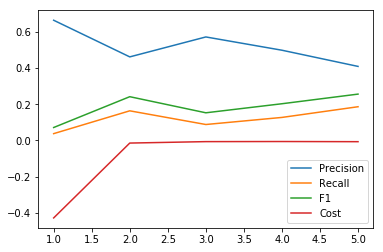

In [288]:
xs = list(range(1,6))
plt.plot(xs, [x["precision"] for x in scores], label="Precision")
plt.plot(xs, [x["recall"] for x in scores], label="Recall")
plt.plot(xs, [x["f1"] for x in scores], label="F1")
plt.plot(xs, [x["cost"] for x in scores], label="Cost")
plt.legend()

## Analyzing Results of Subsets

In [278]:
X_test2 = X_test[X_test["natural_gas_delivery_contract_type_N/A"] == 1]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.6976600985221675
Recall: 0.22764717701426562
F1: 0.3432813210119679
       0     1
0  35934   491
1   3844  1133
Cost Function: -0.08077429351139152


Model performs much better on data where the delivery contract is N/A for some reason

In [279]:
X_test2 = X_test[X_test["natural_gas_delivery_contract_type_N/A"] != 1]
y_test2 = y_test[X_test2.index]
y_pred = results.predict(X_test2)
get_scores(y_test2, y_pred, X_test2)

Precision: 0.9340659340659341
Recall: 0.2190721649484536
F1: 0.35490605427974947
       0   1
0  11895   6
1    303  85
Cost Function: -0.004741251194801035


When the delivery contract isn't unknown or empty, the model doesn't add much benefit, but that's also because there are few price spikes altogether. And the precision is very good.

# Trying Different Depths

In [112]:
for depth in [5, 10, 15, 20, 30]:
    model = DecisionTreeClassifier(random_state=23, criterion='entropy', max_depth=depth)
    results = model.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    get_scores(y_test, y_pred, X_test)

Precision: 0.6085714285714285
Recall: 0.03940795559666975
F1: 0.07402258905299738
       0    1
0  48149  137
1   5192  213
Cost Function: -0.0005723756180906507
Precision: 0.7380952380952381
Recall: 0.15485661424606845
F1: 0.25600244685731766
       0    1
0  47989  297
1   4568  837
Cost Function: -0.003781918939984932
Precision: 0.7251509054325955
Recall: 0.3333950046253469
F1: 0.4567807351077313
       0     1
0  47603   683
1   3603  1802
Cost Function: -0.009581553377898825
Precision: 0.7200360468609192
Recall: 0.4434782608695652
F1: 0.5488893977558965
       0     1
0  47354   932
1   3008  2397
Cost Function: -0.019629702899649003
Precision: 0.7108719052744887
Recall: 0.6109158186864014
F1: 0.6571144278606965
       0     1
0  46943  1343
1   2103  3302
Cost Function: -0.028499225948148677


Precision tops out at depth=10, which is good. Don't need too many levels

# Trying Different Cutoff Thesholds

In [48]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])

for cutoff in [.8, .85, .9, .95, .99]:
    y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(cutoff))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    model = DecisionTreeClassifier(random_state=23, criterion='entropy')
    results = model.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    get_scores(y_test, y_pred, X_test)
    

Precision: 0.783563718992615
Recall: 0.7734579439252336
F1: 0.7784780359326497
       0     1
0  40705  2286
1   2424  8276
Cost Function: -0.11831184418460877
Precision: 0.7680020283975659
Recall: 0.7581977471839799
F1: 0.7630683965234917
       0     1
0  43871  1830
1   1932  6058
Cost Function: -0.08041131426850526
Precision: 0.6982515510434292
Recall: 0.6969412647776319
F1: 0.6975957926371149
       0     1
0  46757  1605
1   1615  3714
Cost Function: -0.04685456535875492
Precision: 0.577818853974122
Recall: 0.5963372758489126
F1: 0.5869320315433721
       0     1
0  49928  1142
1   1058  1563
Cost Function: -0.015292740288847901
Precision: 0.7903225806451613
Recall: 0.735
F1: 0.7616580310880828
       0    1
0  52974  117
1    159  441
Cost Function: -0.0005302167548820255


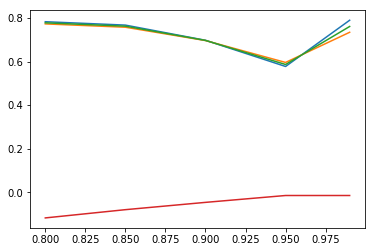

In [55]:
precision = [0.783563718992615, 0.7680020283975659,  0.6982515510434292,   0.577818853974122, 0.7903225806451613]
recall = [0.7734579439252336, 0.7581977471839799, 0.6969412647776319, 0.5963372758489126, 0.735]
f1 = [0.7784780359326497, 0.7630683965234917, 0.6975957926371149, 0.5869320315433721, 0.7616580310880828]
cost = [-0.11831184418460877, -0.08041131426850526, -0.04685456535875492, -0.015292740288847901, -0.015292740288847901]
cutoffs = [.8, .85, .9, .95, .99]
plt.plot(cutoffs, precision)
plt.plot(cutoffs, recall)
plt.plot(cutoffs, f1)
plt.plot(cutoffs, cost)

Maybe .8 is a better cutoff. Could do .98 but 

# Max Depth=10, Fuel Cost Cutoff = .8

## Stratify vs. Not Stratify

In [205]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])

y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.8))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)


In [206]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.6812396236856668
Recall: 0.3443998880910193
F1: 0.4575074331020812
       0     1
0  41240  1728
1   7030  3693
Cost Function: -0.06573906426039261


Looking good. A number of false positives, but few false negatives and good number of true positives.

In [207]:
get_auc(results, y_test, y_pred)

0.8343156195971843

Improved AUC

In [118]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.27450503083414474
Recall: 0.6309801361559265
F1: 0.38257329450679933
       0      1
0  25086  17882
1   3957   6766
Cost Function: -0.06705154161351794
       0      1
0  25086  17882
1   3957   6766
Precision: 0.9548587181254308
Recall: 0.25841648792315586
F1: 0.40675229357798176
       0     1
0  42837   131
1   7952  2771
Cost Function: -0.030963385346891137
       0     1
0  42837   131
1   7952  2771
Precision: 0.922633744855967
Recall: 0.3136249183997016
F1: 0.4681236080178174
       0     1
0  42686   282
1   7360  3363
Cost Function: -0.07957151982534372
       0     1
0  42686   282
1   7360  3363
Precision: 0.4888673765730881
Recall: 0.09419005875221487
F1: 0.15794823676597075
       0     1
0  41912  1056
1   9713  1010
Cost Function: -0.007081946254419294
       0     1
0  41912  1056
1   9713  1010
Precision: 0.5490022172949002
Recall: 0.3463905987688864
F1: 0.4247726882827243
       0     1
0  39917  3051
1   7008  3714
Cost Function: -0.13559833628470905
  

array([-0.06705154, -0.03096339, -0.07957152, -0.00708195, -0.13559834])

In [225]:
np.mean([0.27450503083414474,
0.9548587181254308,
0.922633744855967,
0.4888673765730881,
0.5490022172949002])

0.6379734175367061

In [224]:
np.mean([-0.06705154, -0.03096339, -0.07957152, -0.00708195, -0.13559834])

-0.064053348

Some of the scores are not great. But the costs are pretty good, possibly because of the weighting by quantity in the cost function. And some of the precisions (92%) are really good.

In [119]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])

y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.8))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.27450503083414474
Recall: 0.6309801361559265
F1: 0.38257329450679933
       0      1
0  25086  17882
1   3957   6766
Cost Function: -0.06705154161351794
       0      1
0  25086  17882
1   3957   6766
Precision: 0.9548587181254308
Recall: 0.25841648792315586
F1: 0.40675229357798176
       0     1
0  42837   131
1   7952  2771
Cost Function: -0.030963385346891137
       0     1
0  42837   131
1   7952  2771
Precision: 0.922633744855967
Recall: 0.3136249183997016
F1: 0.4681236080178174
       0     1
0  42686   282
1   7360  3363
Cost Function: -0.07957151982534372
       0     1
0  42686   282
1   7360  3363
Precision: 0.4888673765730881
Recall: 0.09419005875221487
F1: 0.15794823676597075
       0     1
0  41912  1056
1   9713  1010
Cost Function: -0.007081946254419294
       0     1
0  41912  1056
1   9713  1010
Precision: 0.5490022172949002
Recall: 0.3463905987688864
F1: 0.4247726882827243
       0     1
0  39917  3051
1   7008  3714
Cost Function: -0.13559833628470905
  

array([-0.06705154, -0.03096339, -0.07957152, -0.00708195, -0.13559834])

No difference with stratifying.

# Removing Features

In [300]:
X, y = get_xy()
updated_fields = list(X.columns)
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    if b == 0:
        updated_fields.remove(a)

In [301]:
scores = []

for train_index, test_index in folds.split(X[updated_fields]):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=23, max_depth=10)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    scores.append(get_scores(y_test, y_pred, X_test))

       0    1
0  35190  350
1  17465  686
Precision: 0.6621621621621622
Recall: 0.037794060933281914
F1: 0.07150674936154687
Cost Function: -0.4262904463960912
       0    1
0  50935  443
1   1935  378
Precision: 0.46041412911084045
Recall: 0.16342412451361868
F1: 0.2412252712188896
Cost Function: -0.014139870751020273
       0    1
0  51329  147
1   2020  195
Precision: 0.5701754385964912
Recall: 0.08803611738148984
F1: 0.1525224872897927
Cost Function: -0.006199393330628399
       0    1
0  51417  259
1   1759  256
Precision: 0.4970873786407767
Recall: 0.1270471464019851
F1: 0.20237154150197625
Cost Function: -0.005624875064680656
       0    1
0  50965  579
1   1747  399
Precision: 0.40797546012269936
Recall: 0.1859273066169618
F1: 0.25544174135723435
Cost Function: -0.006525741682505816


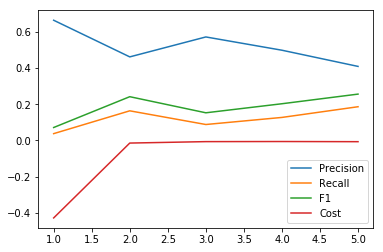

In [302]:
xs = list(range(1,6))
plt.plot(xs, [x["precision"] for x in scores], label="Precision")
plt.plot(xs, [x["recall"] for x in scores], label="Recall")
plt.plot(xs, [x["f1"] for x in scores], label="F1")
plt.plot(xs, [x["cost"] for x in scores], label="Cost")
plt.legend()

No benefit to feature removal.

# Feature Analysis

In [296]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

net_generation_megawatthours 0.2000873804818738
primary_transportation_mode_PL 0.16883292310929898
quantity 0.10335812569910117
mmbtu_per_unit_gen 0.039994980759194054
disturbance_events 0.03738434137843032
operator_id_19876.0 0.03082785674026425
supplier_VARIOUS 0.03022527767189032
operator_id_12745.0 0.028904979342346666
plant_state_NY 0.02545222229682147
plant_id_56328 0.02011661237170358
supplier_LG&E 0.01975793896187076
plant_id_7314 0.019400324671978633
secondary_transportation_mode_PL 0.01928613407717607
operator_id_15296.0 0.016296218437188235
reported_prime_mover_CT 0.015715061493149263
plant_id_8219 0.014097304209078
nerc_region_FRCC 0.013689890470109711
supplier_MUNIGAS - BP ENERGY 0.013618843019710742
nerc_region_WECC 0.01255009168427835
supplier_VIRGINIA POWER SERVICES ENERGY 0.012390891474241312
supplier_BPE 0.009197773077475614
number_affected 0.009191551849669412
plant_id_7552 0.008044831672479377
plant_state_NC 0.007112412537610371
reporting_frequency_A 0.0055162280798

plant_id_55137 0.0
plant_id_55141 0.0
plant_id_55148 0.0
plant_id_55154 0.0
plant_id_55164 0.0
plant_id_55165 0.0
plant_id_55173 0.0
plant_id_55197 0.0
plant_id_55202 0.0
plant_id_55204 0.0
plant_id_55210 0.0
plant_id_55218 0.0
plant_id_55220 0.0
plant_id_55221 0.0
plant_id_55224 0.0
plant_id_55228 0.0
plant_id_55230 0.0
plant_id_55232 0.0
plant_id_55234 0.0
plant_id_55244 0.0
plant_id_55247 0.0
plant_id_55251 0.0
plant_id_55269 0.0
plant_id_55270 0.0
plant_id_55276 0.0
plant_id_55283 0.0
plant_id_55306 0.0
plant_id_55322 0.0
plant_id_55334 0.0
plant_id_55340 0.0
plant_id_55343 0.0
plant_id_55350 0.0
plant_id_55364 0.0
plant_id_55380 0.0
plant_id_55382 0.0
plant_id_55386 0.0
plant_id_55395 0.0
plant_id_55402 0.0
plant_id_55412 0.0
plant_id_55417 0.0
plant_id_55418 0.0
plant_id_55447 0.0
plant_id_55451 0.0
plant_id_55455 0.0
plant_id_55457 0.0
plant_id_55463 0.0
plant_id_55467 0.0
plant_id_55482 0.0
plant_id_55496 0.0
plant_id_55502 0.0
plant_id_55503 0.0
plant_id_55504 0.0
plant_id_555

supplier_FB ENERGY CANADA 0.0
supplier_FGT 0.0
supplier_FIELDWOOD ENERGY LLC 0.0
supplier_FINA 0.0
supplier_FLORIDA GAS 0.0
supplier_FLORIDA GAS UTILITY 0.0
supplier_FLORIDA POWER & LIGHT 0.0
supplier_FORTIS ENERGY MARKETING & TRADING GP 0.0
supplier_FREEPOINT COMMODITIES LLC 0.0
supplier_FURIE OPERATING ALASKA, LLC 0.0
supplier_GAS COMPANY OF NEW MEXICO 0.0
supplier_GASEARCH 0.0
supplier_GAZPROM MT 0.0
supplier_GOLDMAN SACHS 0.0
supplier_GORDONSVILLE 0.0
supplier_GREEN PLAINS TRADE GROUP LLC 0.0
supplier_GULF SOUTH PIPELINE, LP 0.0
supplier_GULF STREAM 0.0
supplier_GULFSOUTH PIPELINE 0.0
supplier_GUNVOR USA LLC 0.0
supplier_Gavilon 0.0
supplier_Gulf South 0.0
supplier_HESS 0.0
supplier_HESS CORP ENERGY MARKETING DIVISION 0.0
supplier_HESS ENERGY 0.0
supplier_HILCORP ENERGY CO 0.0
supplier_HOUSTON PIPE LINE 0.0
supplier_HOUSTON PIPELINE COMPANY 0.0
supplier_HPL 0.0
supplier_HUSKY ENERGY 0.0
supplier_HYDROCARBON EXCHANGE CORP 0.0
supplier_Hess Corp 0.0
supplier_IBERDROLA RENEWABLES 0.0


# Analyze False Positives and Negatives

In [13]:
y_pred = results.predict(X)

In [14]:
wrongs = (y_pred != y)

In [15]:
df_ng["wrong"] = wrongs

In [17]:
df_ng["natural_gas_delivery_contract_type_N/A"].value_counts()

1    207599
0     60855
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

In [16]:
df_ng[df_ng["wrong"] == True]["natural_gas_delivery_contract_type_N/A"].value_counts()

1    3031
0     187
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

In [20]:
print(187/3031)
print(60855/207599)

0.061695809963708347
0.2931372501794325


After some trial and error, large number of incorrect values have a delivery contract of "N/A". Maybe we can subset the data of those values and use a separate model.

# Subsetting the Data  Part 1 - Where Delivery Contract != N/A

In [208]:
df_ng = get_ng()
df_ng2 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] != 1)].copy()
len(df_ng2)
X = df_ng2.drop(columns="fuel_cost")
y = (df_ng2.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [209]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.9473684210526315
Recall: 0.23309352517985613
F1: 0.3741339491916859
       0    1
0  11467    9
1    533  162
Cost Function: -0.000806424142716807


F1 score here is worse, as well as cost, as might be predicted. Although precision is good. 
Running cross_val to see more.
Something about when the delivery contract is known makes prices more unpredictable?

In [210]:
get_auc(results, y_test, y_pred)

0.7289548911585265

In [127]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.7884615384615384
Recall: 0.11614730878186968
F1: 0.2024691358024691
       0   1
0  11444  22
1    624  82
Cost Function: -0.00022294912627997165
       0   1
0  11444  22
1    624  82
Precision: 0.8841059602649006
Recall: 0.3781869688385269
F1: 0.5297619047619048
       0    1
0  11430   35
1    439  267
Cost Function: -0.002058624514887794
       0    1
0  11430   35
1    439  267
Precision: 0.8888888888888888
Recall: 0.28328611898017
F1: 0.4296455424274973
       0    1
0  11440   25
1    506  200
Cost Function: -0.0014410330745351942
       0    1
0  11440   25
1    506  200
Precision: 0.9125
Recall: 0.20679886685552407
F1: 0.3371824480369515
       0    1
0  11451   14
1    560  146
Cost Function: -0.0013844365181518124
       0    1
0  11451   14
1    560  146
Precision: 0.9210526315789473
Recall: 0.14893617021276595
F1: 0.2564102564102564
       0    1
0  11456    9
1    600  105
Cost Function: -0.0006959528478685768
       0    1
0  11456    9
1    600  105


array([-0.00022295, -0.00205862, -0.00144103, -0.00138444, -0.00069595])

Good thing is very few false negatives, good precision. All the cost values are negative, but not by much. 

In [226]:
np.mean([-0.00022295, -0.00205862, -0.00144103, -0.00138444, -0.00069595])

-0.001160598

In [128]:
y_pred = results.predict(X)

In [129]:
wrong = (y != y_pred)

In [130]:
df_ng2["wrong"] = wrong

# Identify Additional Features That Might Be Associated with Innaccurate Predictions
i.e. volatile predictors

In [70]:
df_ng4 = df_ng2[df_ng2["wrong"] == True]

In [206]:
other_cols = []
for col in df_ng4.columns:
    sum_ = df_ng4[col].sum()
    if sum_ >0: other_cols.append(col)


In [89]:
df_ng4[other_cols].sum().reset_index().sort_values(0, ascending=False)[0:50]

,index,0
1,quantity,1.728757e+08
0,fuel_cost,6.623665e+07
4,number_affected,5.058808e+06
10,natural_gas_transportation_service_N/A,1.353000e+03
347,secondary_transportation_mode_N/A,1.353000e+03
344,regulated_REG,1.353000e+03
340,primary_transportation_mode_PL,1.353000e+03
489,wrong,1.353000e+03
5,contract_type_N/A,1.353000e+03
471,combined_heat_and_power_plant_N,1.317000e+03


In [268]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["natural_gas_delivery_contract_type_F"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

0.5309278350515464
      0    1
0  9043    1
1   181  103


0.9810677530017152

In [47]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["nerc_region_SERC"] != 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)
y_pred = results.predict(X_test)

get_scores(y_test, y_pred, X_test)


Precision: 0.9111111111111111
Recall: 0.47674418604651164
F1: 0.6259541984732825
      0    1
0  8449   12
1   135  123
Cost Function: -0.0032483153643423587


In [46]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["natural_gas_supply_contract_type_I"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)



Precision: 0.7272727272727273
Recall: 0.41379310344827586
F1: 0.5274725274725275
      0   1
0  2911  18
1    68  48
Cost Function: -0.0027501330603776197


In [229]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)


Precision: 0.864406779661017
Recall: 0.53125
F1: 0.6580645161290324
      0    1
0  1589   16
1    90  102
Cost Function: -0.030956524926279174


Ok, maybe we've found the volatility feature. Automatic reporting with a specified delivery contract can be modeled decently, but manual reporting is maybe erratic?

In [230]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.9090909090909091
Recall: 0.2631578947368421
F1: 0.4081632653061224
      0   1
0  1602   5
1   140  50
Cost Function: -0.024561188052915052
      0   1
0  1602   5
1   140  50
Precision: 0.8741258741258742
Recall: 0.6578947368421053
F1: 0.7507507507507508
      0    1
0  1589   18
1    65  125
Cost Function: -0.04036119427739065
      0    1
0  1589   18
1    65  125
Precision: 0.8888888888888888
Recall: 0.7157894736842105
F1: 0.7930029154518949
      0    1
0  1590   17
1    54  136
Cost Function: -0.04241117274990806
      0    1
0  1590   17
1    54  136
Precision: 0.8682170542635659
Recall: 0.5925925925925926
F1: 0.7044025157232704
      0    1
0  1589   17
1    77  112
Cost Function: -0.02603025908106917
      0    1
0  1589   17
1    77  112
Precision: 0.7528089887640449
Recall: 0.3544973544973545
F1: 0.4820143884892085
      0   1
0  1584  22
1   122  67
Cost Function: -0.024745282918692706
      0   1
0  1584  22
1   122  67


array([-0.02456119, -0.04036119, -0.04241117, -0.02603026, -0.02474528])

In [231]:
np.mean([-0.02456119, -0.04036119, -0.04241117, -0.02603026, -0.02474528])

-0.031621818

In [ ]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)

In [234]:
get_scores(y_test, y_pred, X_test)

Precision: 0.8823529411764706
Recall: 0.2721774193548387
F1: 0.4160246533127889
      0    1
0  9861   18
1   361  135
Cost Function: -0.000888331166180569


In [235]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.8586956521739131
Recall: 0.1528046421663443
F1: 0.2594417077175698
      0   1
0  9846  13
1   438  79
Cost Function: -0.00020166803171062036
      0   1
0  9846  13
1   438  79
Precision: 0.786096256684492
Recall: 0.28488372093023256
F1: 0.4182076813655761
      0    1
0  9819   40
1   369  147
Cost Function: -0.0003340459475427819
      0    1
0  9819   40
1   369  147
Precision: 0.6879432624113475
Recall: 0.187984496124031
F1: 0.29528158295281587
      0   1
0  9815  44
1   419  97
Cost Function: -0.0012340029092979305
      0   1
0  9815  44
1   419  97
Precision: 0.8652482269503546
Recall: 0.2364341085271318
F1: 0.3713850837138508
      0    1
0  9839   19
1   394  122
Cost Function: -0.0014155594326152455
      0    1
0  9839   19
1   394  122
Precision: 0.9133333333333333
Recall: 0.2655038759689923
F1: 0.41141141141141147
      0    1
0  9845   13
1   379  137
Cost Function: -0.0007910412982559453
      0    1
0  9845   13
1   379  137


array([-0.00020167, -0.00033405, -0.001234  , -0.00141556, -0.00079104])

In [236]:
np.mean([-0.00020167, -0.00033405, -0.001234  , -0.00141556, -0.00079104])

-0.0007952640000000001

In [238]:
np.mean([0.8586956521739131,
0.786096256684492,
0.6879432624113475,
0.8652482269503546,
0.9133333333333333])

0.8222633463106881

In [29]:
# Saving the test and prediction data for later use
leaf1_test = y_test
leaf1_pred = y_pred

In [97]:
cross_val_score(results, X, y, cv=5)

array([0.92150446, 0.94759881, 0.93289418, 0.93574161, 0.94376913])

No abberations in cross_val_score

# Modeling Subset of Data - Delivery Contract == N/A

In [211]:
df_ng=get_ng()
df_ng3 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] == 1)]

X = df_ng3.drop(columns="fuel_cost")
y = (df_ng3.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [212]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.7195068251871423
Recall: 0.32950191570881227
F1: 0.4520055325034578
       0     1
0  30328  1274
1   6650  3268
Cost Function: -0.09547856488281592


Very good scores here. 

In [213]:
get_auc(results, y_test, y_pred)

0.8111649696232606

In [133]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.26490683229813666
Recall: 0.5960866526904263
F1: 0.3668028380993335
       0      1
0  14934  16569
1   4046   5971
Cost Function: -0.11065152058331133
       0      1
0  14934  16569
1   4046   5971
Precision: 0.8347076461769115
Recall: 0.22232205251073175
F1: 0.3511233740638549
       0     1
0  31062   441
1   7790  2227
Cost Function: -0.04016438171107114
       0     1
0  31062   441
1   7790  2227
Precision: 0.8293203291679366
Recall: 0.27163821503444147
F1: 0.40923447134907504
       0     1
0  30943   560
1   7296  2721
Cost Function: -0.11907093627851568
       0     1
0  30943   560
1   7296  2721
Precision: 0.2129032258064516
Recall: 0.11200958370769691
F1: 0.14679139137829528
       0     1
0  27355  4148
1   8895  1122
Cost Function: -0.026741629798990217
       0     1
0  27355  4148
1   8895  1122
Precision: 0.7205683355886333
Recall: 0.21263851452530697
F1: 0.32837431588684185
       0     1
0  30676   826
1   7887  2130
Cost Function: -0.15438196567760298


array([-0.11065152, -0.04016438, -0.11907094, -0.02674163, -0.15438197])

In [227]:
np.mean([-0.11065152, -0.04016438, -0.11907094, -0.02674163, -0.15438197])

-0.090202088

In [228]:
282/5

56.4

Some bad scores in there, but cost function is generally very good. 

Maybe quantities are low when it's inaccurate?

In [316]:
leaf2_pred = y_pred
leaf2_test = y_test

In [44]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True)[0:50]:
    print(a,b)

quantity 0.3065115789271838
net_generation_megawatthours 0.17475143706555196
mmbtu_per_unit_gen 0.047480963780289084
primary_transportation_mode_PL 0.0374495998549301
disturbance_events 0.018158446068185993
operator_id_19876.0 0.008982741182822147
supplier_VARIOUS 0.008915166117318723
number_affected 0.008235850094740683
contract_type_C 0.007901899785417573
operator_id_16534.0 0.007704271132913494
reported_prime_mover_CA 0.007595525358214486
nerc_region_SPP 0.00719590044945642
reported_prime_mover_CT 0.006590752547331757
plant_state_NY 0.006232101040383877
contract_type_S 0.005633602569983541
plant_id_7314 0.005569392988832404
plant_state_NC 0.005080406559838078
supplier_BPE 0.004520729568905825
supplier_MUNIGAS - BP ENERGY 0.004429483889518933
nerc_region_WECC 0.004329706084839921
nerc_region_FRCC 0.004015608478734724
natural_gas_transportation_service_I 0.0036911705047013
supplier_LG&E 0.003651576641632353
operator_id_16572.0 0.0035956908227096724
supplier_IBERDROLA RENEWABLES 0.0034